# 6. Learning Best Practices for Model Evaluation and Hyperparameter Tuning

이 장에서는
- 모델의 성능이 편향되지 않도록 하기
- 기계학습 알고리즘에서 자주 발생하는 문제를 진단
- 기계학습 모델 fine-tune 
- 여러가지 성능 지표를 통해 모델 평가

   를 배울 것이다.

## Streamlining workflows with pipelines

이 장에서는 매우 간편한 툴인 `Pipeline` 클래스를 배울 것이다(scikit-learn). 이 툴은 모델이 여러 변환 과정을 거치는 것을 가능하게 하고, 이 모델로 새로운 데이터를 예측할수 있게 한다.

### Loading the Breast Cancer Wisconsin dataset

malignant / benign class로 나뉘는 데이터셋이고, 이를 이용해 실습을 할 것이다.

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [2]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:,2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [3]:
le.transform(['M', 'B'])

array([1, 0])

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=2)),
('clf', LogisticRegression(random_state=1))])

pipe_lr.fit(X_train, y_train)

print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))


Test Accuracy: 0.947


pipeline의 중간 단계는 scikit-learn의 transformer들로 이루어지고, 마지막으로 estimator가 들어가게 된다. 이 예제에서는 StandardScaler와 PCA가 중간 단계로, 마지막 estimatorf로는 로지스틱 회귀가 들어갔다. 우리가 `pipe_lr`의 `fit` 메소드를 실행시키면 `StandardScaler`가 `fit`과 `transform`을 훈련 데이터셋에 대해 수행하게 되고, 변환된 훈련 데이터셋은 PCA로 옮겨진다. PCA또한 전과 같은 `fit`과 `transform`을 수행하게 된다. _중간 단계의 숫자(수행할수 있는 알고리즘 등)는 제한이 없다._

<img src="ch6_1.png" alt="Drawing" style="width: 700px;"/>

### Using k-fold cross-validation to assess model performance

기계학습에서 보여지지 않은 데이터로 모델의 성능을 측정하는 것은 매우 중요한 작업중 하나이다. 우리가 모델을 훈련 데이터에 fit시키고, 그 데이터를 이용해 또 성능을 평가한다고 가정해 보자. ch3에서 배웠듯, 모델은 너무 underfitting(high bias)되거나 overfit(high variance)될수 있다. bias-variance trade off를 어느정도 허용 가능한 수준으로 조정하려면, 우리 모델을 잘 평가해야 한다. 이 평가 방법들로는 **holdout cross-validation** 과 **k-fold cross validation**이 있다. 이러한 방법들은 모델이 새로운 데이터를 얼마만큼 잘 예측하는지 측정 가능하도록 도와준다.

## The holdout method

클래식하고 인기있는 방법이다. 이 방법을 사용하면, 우리는 우리의 처음 데이터셋을 훈련 데이터 / 테스트 데이터로 분류하게 된다. 하지만, 보통 기계학습을 쓸때는 다른 파라메터 세팅들을 tuning하고 비교해 보는 것 또한 중요하다. 이는 새로운 데이터에 대해 더 좋은 예측을 할 수 있게 하기 때문이다. 이런 과정을 우리는 **model selection**이라고 부르며, 이 말은 주어진 분류 문제에서 tuning parameter들의 최적값을 선택하기를 원한다는 것을 뜻한다(**hyperparameter**라고도 불린다). 하지만, model selection 과정에서 같은 데이터를 계속 다시 사용한다면, 이는 곧 우리의 훈련 데이터의 한 부분으로 되어 버리고 따라서 overfit의 가능성을 높인다. 즉, (같은) 테스트 데이터셋을 계속 사용하는 것은 좋지 않다.  

holdout method를 사용하는 좋은 방법은 데이터를 세 파트로 나누는 것이다: training / validation / test로 말이다. training set은 각 모델들을 fit하는데 쓰이고, validation set으로 측정한 성능에 의해 모델을 선택한다. 이러한 방법을 사용해 더 적게 편향된 예측값을 얻을 수 있다. 

<img src="ch6_2.png" alt="Drawing" style="width: 700px;"/>

Holdout method의 단점은 예측의 성능이 우리가 훈련 데이터를 validation과 training으로 어떻게 나누었는지에 대해 민감하다는 점이다. 다른 샘플에 따라 예측치가 꽤 다를 수 있다. 

## K-fold cross-validation

K-fold cross-validation에서 우리는 훈련 데이터셋은 k개의 fold로 겹치는 부분이 없이 랜덤하게 나눈다. k-1개의 folds는 모델을 훈련시키는데 쓰이고, 나머지 하나는 테스트에 쓰인다. 이러한 과정은 k번 반복되며, 따라서 우리는 k개의 모델과 성능 측정값을 가지게 된다.

*resampling without replacement* : {0,1,2,3,4}중 5개를 뽑을 경우

        Random sampling without replacement: 2, 1, 3, 4, 0
        Random sampling with replacement: 1, 3, 3, 4, 1

우리가 모델의 평균적인 성능을 각각의 독립적 folds를 기반으로 계산한다면, 이는 holdout method에 비해 덜 민감한 예측치를 가지게 한다. 보통, 우리는 k-fold cross-validation을 model tuning을 위해 쓴다. 즉, 이것을 통해 일반적으로 만족스러운 성능을 내는 최적의 hyperparameter 값들을 찾는 것이다. 만족스러운 hyperparameter 값들을 얻게 된다면, 그 모델을 다시 완성된 훈련 데이터를 통해 재훈련시킨 후 독립적인 테스트셋을 통해 마지막 성능 예측치를 얻을 수 있다.

k-fold cross-validation이 replacement 없는 resampling technique이기 때문에, 이 방법의 장점은 각 샘플이 훈련 혹은 테스트 데이터셋에 정확히 한번 들어간다는 것이다. 따라서 holdout method보다 모델의 성능이 좀 더 낮은 variance를 가지게 된다. 

<img src="ch6_3.png" alt="Drawing" style="width: 700px;"/>

보통 k의 값은 10으로 설정한다. 하지만 작은 훈련 데이터셋을 가지고 있을 경우에는 k를 늘리는 것도 좋다. k값을 늘릴수록, 더 많은 훈련 데이터가 모델을 학습시키는데 사용될 것이고 이는 곧 (각 모델의 예측값을 평균낸) 일반적 성능이 더 낮은 bias를 가지게 한다. 하지만, 너무 큰 k값은 cross-validation의 런타임 또한 늘려 결국 훈련 folds가 서로 거의 비슷해지므로 더 높은 variance를 가지게 한다. 만약 우리가 큰 큰 데이터셋을 가지고 있다면 우리는 더 작은 k(5 정도)를 선택할 수 있는데, 그렇게 되면 꽤 정확한 평균 성능을 얻을 수 있는 동시에 computational cost를 줄일 수 있다.

특히나 unequal한 class proportions상황에서는 stratified k-fold cross-validation를 사용한다면 경우 좀더 나은 bias와 variance를 얻을 수 있다. (R. Kohavi et al. A Study of Cross-validation and Bootstrap for Accuracy Estimation and Model Selection. In Ijcai, volume 14, pages 1137–1145, 1995) Stratified cross validation에서 class proportions은 각 fold에 유지된다. (만약 class0이 70%, class1이 30%비중이라면 각 fold에도 이 비중을 맞춰줌)

In [9]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold

kfold = StratifiedKFold(y = y_train, n_folds=10,random_state=1)
scores = []

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))


print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956
CV accuracy: 0.950 +/- 0.029


`cross_val_score`을 통해서도 score 계산이 가능하다.

In [8]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)

print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


`cross_val_score`이 엄청나게 유용한 점은 다른 fold들을 계산할때 multiplte CPU연산이 가능하다는 점이다. 만일 `n_jobs`파라메터를 2로 둔다면, CPU를 2개 사용하여 연산하게 된다.

## Debugging algorithms with learning and validation curves

이 장에서 우리는 학습 알고리즘의 성능을 강화시키기 위한 강력한 진단 툴들을 배울 것이다. **learning curves**와 **validation curves**가 그것이다. 

### Diagnosing bias and variance problems with learning curves

 만약 모델이 너무 복잡하다면, 그 모델은 보통 overfit하는 경향이 있다. 종종 더 많은 훈련 데이터를 모으는 것이 이 overfitting의 강도를 조금 낮춰 줄수는 있다. 하지만, 실전에서 이건 굉장히 비싸거나 때로는 불가능하기도 하다. 모델의 training accuracy와 validation accuracies을 그래프에 그리면, 우리는 이 모델이 high variance를 겪거나 high bias를 겪고 있는지 쉽게 확인이 가능하며 또한 더 많은 데이터를 집어 넣는것이 이 문제를 해결할 수 있을지도 확인 가능하다.

<img src="ch6_4.png" alt="Drawing" style="width: 700px;"/>

    High bias 해결방법: 변수 갯수를 늘리거나, regularization 강도를 줄이거나
    High variance 해결방법: 더 많은 데이터를 모으거나, regularization 강도를 높이거나, 정규화가 되어있지 않은 경우에는 feature selection 혹은 feature extraction
    
더 많은 데이터가 overfitting을 낮춘다는 것은 차후에 설명. 하지만 데이터가 너무 noisy하거나 모델이 이미 최적에 가까운 경우에는 그렇지 않을수 있다.

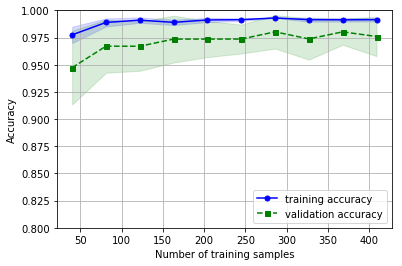

In [12]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=0))])

train_sizes, train_scores, test_scores =\
                        learning_curve(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        train_sizes=np.linspace(0.1, 1.0, 10),
                        cv=10,
                        n_jobs=4)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5,
            label='training accuracy')

plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='validation accuracy')

plt.fill_between(train_sizes, 
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show() # small overfitting

### Addressing overfitting and underfitting with validation curves

Validation curve는 overfitting이나 underfitting 이슈를 해결하기 위한 좋은 툴이다. Validation curve는 learning curve와 관련 되어 있지만, 가로축이 샘플 사이즈가 아닌 모델 파라메터의 값의 변화이다.

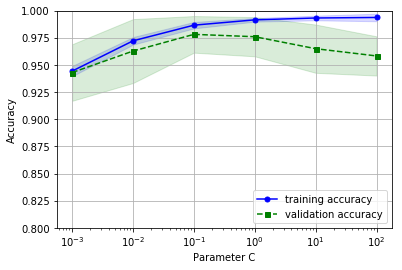

In [13]:
from sklearn.learning_curve import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                            X=X_train,
                                            y=y_train,
                                            param_name='clf__C',
                                            param_range=param_range,
                                            cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
        color='blue', marker='o',
        markersize=5,
        label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                train_mean - train_std, alpha=0.15,
                color='blue')

plt.plot(param_range, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='validation accuracy')

plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')
                 
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

*C: inverse regulization parameter in logistic regression

`learning_curve` 함수와 비슷하게, `validation_curve`함수 또한 분류 모델의 성능을 평가할때 기본적으로 stratified k-fold cross-validation을 수행한다. 위 그래프에서는 C가 0.1정도 값을 가질때 가장 이상적이라고 말할 수 있다.

## Fine-tuning machine learning models via grid search

기계학습에서, 우리는 두가지 종류의 파라메터를 가진다. 훈련 데이터로부터 얻어진 것(로지스틱 회귀에서의 weights), 그리고 따로 최적화된 학습 알고리즘이 그것이다. 후자는 tuning 파라메터로서, 모델의 hyperparamter라고도 불린다. 예를 들어서, 로지스틱 회귀에서 **regularization** 파라메터나 decision tress에서의 **depth**가 그것이다.

### Tuning hyperparameters via grid search

grid search는 꽤 간단하다. 다른 hyperparameter들의 리스트 값들을 정해주고, 컴퓨터가 모델 성능을 위한 최적의 조합을 찾는다.

    만약 random forest라면, 밑의 4개 hyperparameter들중 최적의 조합을 고르게 된다. 
    n_estimators = [10, 50, 100, 200]
    criterion = ['gini', 'entropy']
    max_depth = [None, 100, 10]
    min_samples_leaf = [1, 5, 10, 20]
    여기서는 4*2*3*4=96가지의 조합을 평가해야 한다.

In [15]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
            'clf__kernel': ['linear']},
            {'clf__C': param_range,
            'clf__gamma': param_range,
            'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=10,
                    n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)


0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}


위 코드는 linear SVM이라서 `clf__C`만 hyperparameter의 대상이다. `param_range`중 0.1이 가장 적합한 것을 알 수 있다. 마지막으로, 독립된 테스트 데이터로 선택된 모델의 성능을 평가한다.

In [16]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))


Test accuracy: 0.965


*grid search는 컴퓨팅 시간이 매우 길기 때문에, randomized search를 이용하기도 한다. (http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization 참고)

## Algorithm selection with nested cross-validation

k-fold cross-validation과 grid search를 같이 쓰는 것은 hyperparameter들을 조정하며 좋은 모델을 만드는데 사용되었다. 하지만 만약 다른 기계학습 알고리즘 중 하나를 선택해야 한다면, nested cross-validation을 써야 한다. 

**5*2 cross-validation**

<img src="ch6_5.png" alt="Drawing" style="width: 700px;"/>

nested cross-validation에서는 training fold를 또한번 k-fold cross validation해준후 model selection에 사용한다. 모델 선택 후에, test fold는 모델 성능을 평가하는데 사용된다. 

In [18]:
gs = GridSearchCV(estimator=pipe_svc,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=10,
                    n_jobs=-1)

scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.972 +/- 0.012


이를 가지고, SVM모델과 비교해 볼수도 있다.

In [19]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                    param_grid=[
                        {'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                    scoring='accuracy',
                    cv=5)

scores = cross_val_score(gs, 
                         X_train,
                         y_train,
                         scoring='accuracy',
                          cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.908 +/- 0.045


결과적으로, SVM 모델의 예측력이 훨씬 높게 나왔고 따라서 이 모델을 정해 다시 학습시킨다.